# Predicting Reddit Text-Data Post Popularity using NLP and Classification

In [113]:
import warnings
warnings.filterwarnings('ignore')
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string
import wordcloud
import json
import requests
from datetime import datetime as dt
import bz2
import csv
import zstandard

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# nltk.download('vader_lexicon')
# nltk.download('stopwords')
# nltk.download('words')

from multiprocessing import Pool
import joblib

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import (accuracy_score, classification_report, 
                             mean_absolute_error, mean_squared_error, r2_score, roc_auc_score)

from sklearn.model_selection import GridSearchCV, KFold

%matplotlib inline


def fullprint(*args, **kwargs):
    """Prints the entire matrix/text without changing default jupyter settings"""
    from pprint import pprint
    import numpy
    opt = numpy.get_printoptions()
    numpy.set_printoptions(threshold=numpy.inf)
    pprint(*args, **kwargs)
    numpy.set_printoptions(**opt)

# Data gathering

In [2]:
# with bz2.open('data/RS_2017-01.bz2', 'rt', encoding="cp866") as subfile:
#     sub_2017=[]
#     for i, line in enumerate(subfile):
#         if i == 250000:
#             break
#         reddit = json.loads(line)
#         sub_2017.append(reddit)
        
# sub_2017.to_csv('data/reddit_submissions_2017.csv')

# with bz2.open('data/RC_2017-01.bz2', 'rt', encoding="cp866") as subfile:
#     com_2017=[]
#     for i, line in enumerate(subfile):
#         if i == 250000:
#             break
#         reddit = json.loads(line)
#         com_2017.append(reddit)
        
# com_2017.to_csv('data/reddit_comments_2017.csv')

In [3]:
subs_2017_data = pd.read_csv('../data/reddit_submissions_2017.csv', index_col="id" )

subs_2017_data

,link_flair_css_class,thumbnail,created_utc,spoiler,locked,distinguished,hidden,stickied,quarantine,retrieved_on,...,mobile_ad_url,promoted_url,imp_pixel,href_url,adserver_click_url,original_link,third_party_tracking,promoted,promoted_by,promoted_display_name
id,,,,,,,,,,,,,,,,,,,,,
0,NaN,https://b.thumbs.redditmedia.com/ZchXykM_bboD2...,1483228800,False,False,NaN,False,False,False,1489388027,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,default,1483228800,False,False,NaN,False,False,False,1489388027,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,question,self,1483228800,False,False,NaN,False,False,False,1489388027,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,self,1483228800,False,False,NaN,False,False,False,1489388027,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,solvedcase,self,1483228801,False,False,NaN,False,False,False,1489388027,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,NaN,default,1483317995,False,False,NaN,False,False,False,1489391176,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
249996,NaN,default,1483317995,False,False,NaN,False,False,False,1489391176,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
249997,que,default,1483317996,False,False,NaN,False,False,False,1489391176,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
subs_2017_data.columns

Index(['link_flair_css_class', 'thumbnail', 'created_utc', 'spoiler', 'locked',
       'distinguished', 'hidden', 'stickied', 'quarantine', 'retrieved_on',
       'domain', 'secure_media', 'secure_media_embed', 'title', 'author',
       'post_id', 'num_comments', 'permalink', 'selftext', 'archived', 'url',
       'subreddit', 'contest_mode', 'subreddit_id', 'media', 'score',
       'suggested_sort', 'author_flair_css_class', 'hide_score', 'preview',
       'edited', 'author_flair_text', 'link_flair_text', 'is_self',
       'media_embed', 'brand_safe', 'over_18', 'post_hint', 'gilded',
       'author_cakeday', 'adserver_imp_pixel', 'third_party_tracking_2',
       'disable_comments', 'mobile_ad_url', 'promoted_url', 'imp_pixel',
       'href_url', 'adserver_click_url', 'original_link',
       'third_party_tracking', 'promoted', 'promoted_by',
       'promoted_display_name'],
      dtype='object')

In [5]:
subs_2017_data.shape

(250000, 53)

# Cleaning and Preprocessing

In [6]:
subs_2017_data.isna().sum()

link_flair_css_class      191133
thumbnail                      0
created_utc                    0
spoiler                        0
locked                         0
distinguished             248280
hidden                         0
stickied                       0
quarantine                     0
retrieved_on                   0
domain                         0
secure_media              221614
secure_media_embed             0
title                          0
author                         0
post_id                        0
num_comments                   0
permalink                      0
selftext                  115419
archived                       0
url                            0
subreddit                     91
contest_mode                   0
subreddit_id                  91
media                     221227
score                          0
suggested_sort            226615
author_flair_css_class    215334
hide_score                     0
preview                   165441
edited    

In [7]:
subs_2017_data =subs_2017_data.drop(['author_cakeday',
       'adserver_imp_pixel', 'third_party_tracking_2', 'disable_comments',
       'mobile_ad_url', 'promoted_url', 'imp_pixel', 'href_url',
       'adserver_click_url', 'original_link', 'third_party_tracking',
       'promoted', 'promoted_by', 'promoted_display_name','post_hint','author_flair_text','link_flair_text','preview','suggested_sort',
       'author_flair_css_class','media', 'secure_media','distinguished','link_flair_css_class','secure_media_embed'],axis =1)

In [8]:
print(subs_2017_data.columns)
subs_2017_data.shape

Index(['thumbnail', 'created_utc', 'spoiler', 'locked', 'hidden', 'stickied',
       'quarantine', 'retrieved_on', 'domain', 'title', 'author', 'post_id',
       'num_comments', 'permalink', 'selftext', 'archived', 'url', 'subreddit',
       'contest_mode', 'subreddit_id', 'score', 'hide_score', 'edited',
       'is_self', 'media_embed', 'brand_safe', 'over_18', 'gilded'],
      dtype='object')


(250000, 28)

In [9]:
subs_2017_data = subs_2017_data.drop(['spoiler', 'locked', 'hidden', 'stickied', 'quarantine', 'retrieved_on',
                  'permalink', 'archived', 'contest_mode', 'subreddit_id', 'hide_score', 'edited', 'media_embed', 'brand_safe'], axis=1)

In [10]:
print(subs_2017_data.shape)
subs_2017_data.columns

(250000, 14)


Index(['thumbnail', 'created_utc', 'domain', 'title', 'author', 'post_id',
       'num_comments', 'selftext', 'url', 'subreddit', 'score', 'is_self',
       'over_18', 'gilded'],
      dtype='object')

**Binarizing Data Columns**

In [11]:
subs_2017_data.num_comments.value_counts()

0       95268
1       45626
2       18793
3       12806
4       10480
        ...  
1188        1
1316        1
2340        1
1235        1
1151        1
Name: num_comments, Length: 757, dtype: int64

In [12]:
threshold = 2
subs_2017_data['BinarisedNum_Comments'] = (subs_2017_data['num_comments'] >= threshold).astype(np.int)

In [13]:
subs_2017_data['BinarisedNum_Comments'].value_counts(normalize=True)

0    0.563576
1    0.436424
Name: BinarisedNum_Comments, dtype: float64

In [14]:
print(subs_2017_data.is_self.value_counts())
print(subs_2017_data.over_18.value_counts())

True     126420
False    123580
Name: is_self, dtype: int64
False    225708
True      24292
Name: over_18, dtype: int64


In [15]:
threshold = True
subs_2017_data['Binarised_is_self'] = (subs_2017_data['is_self'] >= threshold).astype(np.int)

In [16]:
subs_2017_data['Binarised_is_self'].value_counts(normalize=True)

1    0.50568
0    0.49432
Name: Binarised_is_self, dtype: float64

In [17]:
threshold = True
subs_2017_data['Binarised_over_18'] = (subs_2017_data['over_18'] >= threshold).astype(np.int)

In [18]:
subs_2017_data['Binarised_over_18'].value_counts(normalize=True)

0    0.902832
1    0.097168
Name: Binarised_over_18, dtype: float64

In [19]:
def utc2local_weekday_hour(utctime):
    """
       input: utc-time stamp
       output: tuple (weekday, hour)
       process: removes time-offset from epoch value and calculates day and hours
    interpretation: 
        0-6 is Monday-Sunday
        0-23 is 12AM to 12PM"""
    #creates time.struct_time(tm_year, tm_mon, tm_mday, tm_hour, tm_min, tm_sec, tm_wday, tm_yday, tm_isdst) covert to timestamp
    epoch = time.mktime(dt.fromtimestamp(utctime).timetuple()) 
    offset = dt.fromtimestamp(epoch) - dt.utcfromtimestamp(epoch) #record time-offset
    
    current_timestamp = utctime + offset.total_seconds()  #removes time-difference
    current_timetuple = dt.fromtimestamp(current_timestamp).timetuple() #create time-struct
    
    weekday = current_timetuple.tm_wday
    hour = current_timetuple.tm_hour 
    
    return (weekday, hour) #required tuple format
    


In [20]:
# timestamp to tuples

subs_2017_data["time_day_hour"] = subs_2017_data["created_utc"].apply(lambda x: utc2local_weekday_hour(x))

In [198]:
# subs_2017_data 

In [22]:
# subs_2017_data = subs_2017_data.drop(['num_comments'], axis=1)
# subs_2017_data = subs_2017_data.drop(['is_self'], axis=1)
# subs_2017_data = subs_2017_data.drop(['over_18'], axis=1)
# subs_2017_data = subs_2017_data.drop(['created_utc'], axis=1)

# Cuts down to 10 columns

**Important columns to look out for :**

**1.   created_utc:** *(large integer)* The date and time of post in UTC standard  
**2.   num_comments:** *(integer)* number of comments on the post  
**3.   title:** *(string)* Title of post  
**4.   author:** *(string)* Author  
**5.   is_self:** *(boolean)* Is true if the post is original, False if it is an external reddit post link  
**6.   selftext:** *(string)* If is_self is true, then the self-text associated with the post  
**7.   over_18:** *(boolean)* is the post adult content or not  
**8.   domain:** *(string)* the domain of the post content  
**9.   gilded:** *(integer)* number of gold awards received on the post  
**10.  url:** *(string | url)* links attached to the post   
**11.  thumbnail:** *(string | url)* the image associated with the post category (default | nsfw | image, etc.)   

In [23]:
subs_2017_data.title.str.len()
# subs_2017_data.title.str.len().min()
# subs_2017_data.title.str.len().min()
# subs_2017_data[subs_2017_data.title.str.len() == 1]["title"]

id
0         45
1         46
2         31
3         50
4         60
          ..
249995    27
249996    16
249997    22
249998    57
249999    51
Name: title, Length: 250000, dtype: int64

In [24]:
subs_2017_data.selftext.str.len()
# subs_2017_data.selftext.str.len().min()
# subs_2017_data.selftext.str.len().min()
# subs_2017_data[subs_2017_data.selftext.str.len() == 1]["selftext"]

id
0            NaN
1            9.0
2          492.0
3          375.0
4          738.0
           ...  
249995       9.0
249996       9.0
249997       9.0
249998       NaN
249999    2088.0
Name: selftext, Length: 250000, dtype: float64

In [25]:
subs_2017_data[subs_2017_data.selftext.str.len() == 1]["title"]

id
1104             [Date] It is now Sunday, November/December
5220      Why did it take until 1997 (150 years later) f...
7948      What's the most awkward thing you have encount...
16301                       no one will see this but im gay
19833     [Xbox] [H] Striker Crim Lights [W] 3x Reg Crim...
                                ...                        
226508                       How was your first day of 2017
227992    My boss tries to be my bestfriend and takes ad...
231406    If someone were to dig through your trash what...
239653    [PC] [H] Striker Heatwave, Tactician Heatwave ...
246905                        [PC] [H] Pink FSL [W] 10keys!
Name: title, Length: 62, dtype: object

**We can assume that the self text is nothing but a part of the title. if it is empty, we can replace it with "" (empty string) then we can concatenate both, and process on the combined data.**

In [26]:
print(subs_2017_data.iloc[249999]["title"] + "\n" + subs_2017_data.iloc[249999]["selftext"])

My family line is in danger of dying out... advice?
So I'm an alum of a chapter of a social STEM/engineering sorority that was only installed about a year and a half ago. My family is the only line that does not originate from a founding mother/member (there are only 4 in alpha class), and my little is thinking of dropping. I, and my little, have noticed that our line is where they tend to put the "strange" ones, or the ones who don't quite fit in with the rest, with one little at a time (there are no twins in our line). 

My little has repeatedly voiced concerns to me that she doesn't feel like the other members value her or treat her like a sister. I totally understand where she's coming from as my experience was not too different from that, but I also know that you get out of a sorority what you put in and that these kinds of things are fairly common. I'm really close with my little and she's also close with a few others, so she definitely has felt like it's been of some value to he

In [27]:
# concatenating title and selftext (subtitle) to a single column, 
# after replacing null values

subs_2017_data['title_text'] = subs_2017_data["title"] + "\n" + subs_2017_data["selftext"].fillna("")

In [28]:
subs_2017_data["title_text"][4]

'[TOMT][song][musician] Children\'s cassette tape from the 90s\nWhen I was younger (born in 1993), I had a cassette tape of children\'s songs sung by this one man whose name I don\'t know. I had never heard the songs before so I thought they were originals of this man. Turns out they\'re not, so it\'s hard for me to find the particular version/musician who sang these songs. If anyone could help, you\'d be gratefully feeding my nostalgia!! As I typed out some of the songs, I realize that this may have been a cassette of Christian songs for kids possibly?? Some songs included: \n\n-He\'s got the whole world in his hands \n-Mama\'s little baby loves shortnin bread \n-Who built the ark? Noah, Noah! \n-A song I can\'t find anywhere but the lyrics include "soap, soap, gotta wash your hands with soap, soap" omg'

In [29]:
# Making a copy of the file

subs_2017_data_clean = subs_2017_data.copy()

**The Transcript contains alien languages, symbols and characters like the following**  
ДВУХЪЯРУСНАЯ КРОВАТЬ ДВУХЪЯРУСНАЯ КРОВАТЬ своими руками СВОИМИ РУКАМИ  
যে কারনে সংবাদ শিরোনাম ছিলো সিলেট  সাল জুড়ে   
Các phong cách áo vest chú rể cực chất từ xưa mà không hề lỗi thời   
चुनाव आयोग पहुंची सपा की लड़ाई चुनाव चिन्ह ‘साइकिल’ पर मंडराए खतरे के बादल  
“” ‘’  
İstanbul’da Reina gece kulübüne silahlı saldırı Ölü ve yaralılar var  
ما هاذا الهراء الذي اراه  

sample string to test `clean_text_regex(a)` is shown:
`a = "İstanbul’da Reina gece kulübüne silahlı saldırı Ölü ve yaralılar var चुनाव आयोग ما هاذا الهراء الذي اراه sssd sdsds sad ??/ http://www.google.com (https://www.web.com) 🙀🤔🥂 'hey there' \n So [squareb]"`

In [30]:

only_english = set(nltk.corpus.words.words()) #set of nltk english words
def clean_text_regex(text):
    
    sample = text
    
    sample = re.sub(r"\S*https?:\S*", '', sample) #links and urls
    sample = re.sub('\[.*?\]', '', sample) #text between [square brackets]
    sample = re.sub('\(.*?\)', '', sample) #text between (parenthesis)
    sample = re.sub('[%s]' % re.escape(string.punctuation), '', sample) #punctuations
    sample = re.sub('\w*\d\w', '', sample) #digits with trailing or preceeding text
    sample = re.sub('\n', ' ', sample) #new line character
    sample = re.sub("[''""...“”‘’…]", '', sample) #list of quotation marks
           
    sample = ' '.join([w for w in nltk.wordpunct_tokenize(sample) if w.lower() in only_english or not w.isalpha()]) #doesn't remove indian languages
    sample = ' '.join(list(filter(lambda ele: re.search("[a-zA-Z\s]+", ele) is not None, sample.split()))) #languages other than english
    
    sample = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE).sub(r'', sample) #emojis and symbols
    
    return sample


# Caching stopwords outside for better speed
stops = set(stopwords.words('english'))
def remove_stop_words(text, cores = 2):
    
    sample = text
    sample = sample.lower()
#     with Pool(processes=cores) as pool:
    sample = [word for word in sample.split() if not word in stops]
    sample = ' '.join(sample)
    
    return sample


# Try SnowBallStemmer or pystemmer or pool for multiprocessing
ps = PorterStemmer()
def stem_clean_text(text, cores = 1):
 
    sample = text
    sample = sample.split()
#     with Pool(processes=cores) as pool:
#         sample = pool.map(ps.stem, sample)
    sample = [ps.stem(word) for word in sample]
    sample = ' '.join(sample)
    
    return sample


In [31]:
# # Uncomment everything to run, if joblib file is lost (set range complete 0-250000)

# start = time.time()
# print(dt.fromtimestamp(start))
# sample_series = subs_2017_data_clean["title_text"].apply(lambda x: clean_text_regex(x))

# print(time.time() - start)

In [32]:
# # Uncomment everything to run, if joblib file is lost (set range complete 0-250000)

# start = time.time()
# print(dt.fromtimestamp(start))


# for i in range(0,250000):
#     print("Iteration #", i)
#     sample_series[i] = remove_stop_words(sample_series[i])


# print(time.time() - start)

In [33]:
# # Uncomment everything to run, if joblib file is lost (set range complete 0-250000)

# start = time.time()
# print(start)

# for i in range(114453,250000):
#     print("Iteration #", i)
#     sample_series[i] = stem_clean_text(sample_series[i])
    
    
# print(time.time() - start)

**testing sample for sentiment analysis**

In [34]:
# senti_texts = subs_2017_data_clean["title_text"].apply(lambda x: clean_text_regex(x))

# senti_texts = senti_texts.apply(lambda x: remove_stop_words(x))

# senti_texts

# # loaded and used in the later stage of project for sentiment
# # analysis, scroll down after

In [35]:
# # Saved checkpoint for sentiment analysis later

# joblib.dump(senti_texts, "../data/senti_texts.joblib", compress=1)
# print("Saved un-stemmed texts for sentiment analysis as: senti_texts.joblib(pd.Series)")

**the cleaned text-data series is saved for backup below**

In [36]:
# saving checkpoint file to avoid running functions again
# with open('../data/series_transcript_clean_stemmed.joblib', 'wb') as file:
#     joblib.dump(sample_series, file,compress=1)
#     print("File saved at ", file)



**uncomment and load the text-data series below, change the path to location of joblib file on your device**

In [38]:
# # UNCOMMENT TO LOAD PRESAVED SERIES OF CLEANED TEXT-DATA

# with open("../data/series_transcript_clean_stemmed.joblib", 'rb') as file:
#     sample_series = joblib.load(file)
# sample_series

id
0                      south event next weekend come compet
1                                        think end rogu one
2         question free month hello mobil wont new sinc ...
3         good year buddi mine go visit famili went chec...
4         tape younger tape sung one man whose name dont...
                                ...                        
249995                                 cant continu journey
249996                                              wow big
249997                                         deal breakup
249998                                    eps1 rank royalti
249999    famili line danger die advic alum chapter soci...
Name: title_text, Length: 250000, dtype: object

In [39]:
subs_2017_data_clean["transcript_clean"] = sample_series

In [40]:
subs_2017_data_clean[["transcript_clean", "title_text"]]

,transcript_clean,title_text
id,,
0,south event next weekend come compet,South Dakota event next weekend come compete!\n
1,think end rogu one,What did you think of the ending of Rogue One?...
2,question free month hello mobil wont new sinc ...,Noob question about free month.\nHello I'm on ...
3,good year buddi mine go visit famili went chec...,"It's all about good friends, and Year of the R..."
4,tape younger tape sung one man whose name dont...,[TOMT][song][musician] Children's cassette tap...
...,...,...
249995,cant continu journey,Can't continue the journey?\n[removed]
249996,wow big,Wow! Its so big!\n[deleted]
249997,deal breakup,Dealing with a breakup\n[removed]


In [41]:
# labelling thumbnail urls to custom, and splitting domain of post (extra preprocessing and cleaning)

def strip_domain(text): 
    sample = text
    sample = sample.split(".")[0]
    if sample in ["i", "self","gps", "m", "cdn"]:
        sample = text
        sample = sample.split(".")[1]
    
    return sample
    
subs_2017_data_clean["domain"] = subs_2017_data_clean["domain"].apply(lambda x: strip_domain(x))

def label_thumbnails(text):
    sample = text
    sample = re.sub(r"\S*https?:\S*", 'custom', sample)
    
    return sample
    
subs_2017_data_clean["thumbnail"] = subs_2017_data_clean["thumbnail"].apply(lambda x: label_thumbnails(x))

In [44]:
print(subs_2017_data_clean["domain"].value_counts())
print(subs_2017_data_clean["thumbnail"].value_counts())

# youtu is youtube but truncated, can be cleaned further if needed

imgur                   26040
reddituploads           16013
youtube                 15255
redd                     8834
AskReddit                7907
                        ...  
ipwatchdog                  1
DFWdiscgolf                 1
PokemonGoSpoofing           1
game2winter                 1
bingbongdingdankgong        1
Name: domain, Length: 20704, dtype: int64
default    98915
self       77250
custom     58880
nsfw       12587
image       2251
spoiler      117
Name: thumbnail, dtype: int64


**Sentiment Analysis**: positive vs negative score

In [47]:
# senti_text is cleaned-stopped text, unstemmed, for polarity prediction
# SIA is Sentiment Intensity Analyser by 
# VADER(Valence Aware Dictionary for Sentiment Reasoning)
# This operation will take a while, due to brute-force approach

senti_texts = joblib.load("../data/senti_texts.joblib")
tknzr = RegexpTokenizer('\w+|\$[\d\d]+|http\S+')

sia = SIA()
cleaned_sents = senti_texts.to_list()
lemm = WordNetLemmatizer()
sent_sentiment = []

start = time.time()
for sent in cleaned_sents:
    posi = 0
    nega = 0
    for word in tknzr.tokenize(sent):
        word = lemm.lemmatize(word)
        posi += sia.polarity_scores(word)["pos"]
        nega += sia.polarity_scores(word)["neg"]
    
    sent_sentiment.append({"sentence": sent, "polarity": posi - nega})

print(time.time() - start)
# This output will be appended to the original dataframe and stored
# below to avoid rerunning.

id
0                     south event next weekend come compete
1                                    think ending rogue one
2         question free month hello mobile wont new sinc...
3         good year buddy mine go visit family went chec...
4         tape younger tape sung one man whose name dont...
                                ...                        
249995                                cant continue journey
249996                                              wow big
249997                                      dealing breakup
249998                                    eps1 rank royalty
249999    family line danger dying advice alum chapter s...
Name: title_text, Length: 250000, dtype: object

In [44]:
only_sentiment_polarity = pd.DataFrame(sent_sentiment)

subs_2017_data_clean["polarity"] = only_sentiment_polarity["polarity"]
only_sentiment_polarity["scores"] = subs_2017_data_clean["score"]

**this saved data contains binarised as well as original columns**

In [426]:
# # Saving clean dataframe to csv for backup

# subs_2017_data_clean.to_csv("../data/subs_2017_data_clean.csv")



**load the cleaned dataset below and work on it following from there**

In [57]:
# # UNCOMMENT TO LOAD THE CLEAN-TEXT DATAFRAME
# subs_2017_data_clean = pd.read_csv("../data/subs_2017_data_clean.csv", index_col="id")

# subs_2017_data_clean.head()

# subs_2017_data_clean["transcript_clean"].fillna(" ",inplace=True)
# subs_2017_data_clean.isna().sum()

thumbnail                     0
created_utc                   0
domain                        0
title                         0
author                        0
post_id                       0
num_comments                  0
selftext                 115419
url                           0
subreddit                    91
score                         0
is_self                       0
over_18                       0
gilded                        0
BinarisedNum_Comments         0
Binarised_is_self             0
Binarised_over_18             0
title_text                    0
transcript_clean              0
time_day_hour                 0
polarity                      0
dtype: int64

### **Word-embedding with weighted Tf-Idf method**

In [160]:
# #Countvectorizer for frequency based, Tf-Idf for weighted vectorization.
# # DO NOT UNCOMMENT IF NOT NEEDED

# cv = CountVectorizer(stop_words='english')

# subs_2017_data_cv = cv.fit_transform(corpus)

# feature_array = cv.get_feature_names()

# subs_2017_data_dtm = pd.DataFrame(subs_2017_data_cv.toarray(), columns=cv.get_features_names())

# print('Frequency: \n', sorted(list(zip(cv.get_feature_names(), 
#                                          subs_2017_data_cv.sum(0).getA1())),
#                             key=lambda x: x[1], reverse=True)[:top_n])
# # prints:
# # Frequency: 
# #  [('document', 2), ('aim', 1), ('capture', 1)]


In [58]:
corpus = subs_2017_data_clean["transcript_clean"].values

vectorizer = TfidfVectorizer(stop_words='english')

subs_2017_vector = vectorizer.fit_transform(corpus)
# (2.50K, words, weights)

# 33800

In [59]:
feature_array = vectorizer.get_feature_names()

top_n = 50

print('tf_idf scores: \n', sorted(list(zip(vectorizer.get_feature_names(), 
                                             subs_2017_vector.sum(0).getA1())), 
                                 key=lambda x: x[1], reverse=True)[:top_n])


tf_idf scores: 
 [('new', 7243.938805697949), ('year', 5303.4559015371215), ('happi', 3600.0138365557536), ('like', 2977.3494298505766), ('look', 2727.4054572419955), ('game', 2576.147620005746), ('time', 2446.265898671936), ('know', 2059.0835861878213), ('help', 1998.7789623726997), ('good', 1914.4190765541293), ('dont', 1853.9704182086768), ('best', 1851.5335232264586), ('day', 1818.2853694328787), ('anyon', 1817.6964282108408), ('want', 1801.1829366507984), ('need', 1788.4762989165365), ('make', 1749.068597714641), ('peopl', 1721.8615766298522), ('think', 1689.3243970590565), ('work', 1513.4926248705522), ('use', 1486.9338618758097), ('got', 1480.7895685709716), ('post', 1479.3911155330559), ('tri', 1469.569616982099), ('thank', 1461.081309735889), ('pleas', 1378.6896805545705), ('realli', 1337.12983102481), ('play', 1328.144552919972), ('love', 1325.0400717248967), ('start', 1320.9668214331289), ('way', 1289.0604743030688), ('come', 1167.1706370064014), ('someon', 1115.528408318341

In [60]:
print('idf values: \n', sorted(list(zip(feature_array,vectorizer.idf_,)),
       key = lambda x: x[1], reverse=True)[:top_n])


idf values: 
 [('3s', 12.736073016276439), ('4x4', 12.736073016276439), ('5i', 12.736073016276439), ('9oclock', 12.736073016276439), ('a9', 12.736073016276439), ('aa0', 12.736073016276439), ('aa2', 12.736073016276439), ('aa3', 12.736073016276439), ('aa6', 12.736073016276439), ('aaditpull3', 12.736073016276439), ('aai2', 12.736073016276439), ('aardvark', 12.736073016276439), ('aba1', 12.736073016276439), ('abash', 12.736073016276439), ('abdal', 12.736073016276439), ('abet', 12.736073016276439), ('abjur', 12.736073016276439), ('ablat', 12.736073016276439), ('abletonpush2', 12.736073016276439), ('aboard5', 12.736073016276439), ('aborigin', 12.736073016276439), ('aboveground', 12.736073016276439), ('abracadabra', 12.736073016276439), ('abrog', 12.736073016276439), ('abscond', 12.736073016276439), ('absolv', 12.736073016276439), ('abulia', 12.736073016276439), ('abuse3', 12.736073016276439), ('abuse4', 12.736073016276439), ('acana', 12.736073016276439), ('acca', 12.736073016276439), ('accou

# Model-Corpus Preparation

`subs_2017_data_clean.columns`

Index(['thumbnail', 'created_utc', 'domain', 'title', 'author', 'post_id',  
       'num_comments', 'selftext', 'url', 'subreddit', 'score', 'is_self',  
       'over_18', 'gilded', 'BinarisedNum_Comments', 'Binarised_is_self',  
       'Binarised_over_18', 'time_day_hour', 'title_text', 'transcript_clean',  
       'polarity'],  
      dtype='object')
      
For preparing a model ready corpus, we have to numerize the categorical values, and also drop the duplicate columns, futher, the data is required to be cut short. The firther process is done below:

In [78]:
# subs_2017_data_clean.drop(['created_utc', 
#                            'title', 'author', 
#                            'post_id', 'num_comments', 
#                            'selftext', 'url', 'is_self', 'over_18', 
#                            'title_text'], axis =1, inplace=True)


,thumbnail,domain,subreddit,score,gilded,BinarisedNum_Comments,Binarised_is_self,Binarised_over_18,transcript_clean,time_day_hour,polarity
0,default,AskReddit,AskReddit,0,0,1,1,0,think end rogu one,"(6, 11)",0.0
1,self,ffxiv,ffxiv,0,0,1,1,0,question free month hello mobil wont new sinc ...,"(6, 11)",4.0
2,self,tipofmytongue,tipofmytongue,0,0,1,1,0,tape younger tape sung one man whose name dont...,"(6, 11)",1.0
3,self,nba,nba,0,0,1,1,0,game thread new york gener inform time media l...,"(6, 11)",-2.0
4,self,every15min,every15min,0,0,0,1,0,current current,"(6, 11)",0.0


In [62]:
subs_2017_data_clean.isna().sum()
# subs_2017_data_clean.dropna(inplace=True) #run if there are null values visible in the below result

thumbnail                 0
domain                    0
subreddit                91
score                     0
gilded                    0
BinarisedNum_Comments     0
Binarised_is_self         0
Binarised_over_18         0
transcript_clean          0
time_day_hour             0
polarity                  0
dtype: int64

In [63]:
reddits = subs_2017_data_clean.subreddit.value_counts(ascending=True)
reddits

militaryrations            1
discovertheweb             1
freeonlinegaming           1
Picklestasteg00d           1
EmiliaClarke               1
                        ... 
GlobalOffensiveTrade    2820
The_Donald              3041
removalbot              3119
RocketLeagueExchange    7020
AskReddit               7907
Name: subreddit, Length: 20888, dtype: int64

In [64]:
dead_subs = reddits[reddits < 100].index.to_list()

len(dead_subs)

20535

In [65]:
reddits = reddits.drop(dead_subs)
reddits.sum()

128425

In [66]:
subs_2017_data_clean = subs_2017_data_clean[~subs_2017_data_clean["subreddit"].isin(dead_subs)]

subs_2017_data_clean

,thumbnail,domain,subreddit,score,gilded,BinarisedNum_Comments,Binarised_is_self,Binarised_over_18,transcript_clean,time_day_hour,polarity
id,,,,,,,,,,,
1,default,AskReddit,AskReddit,1,0,1,1,0,think end rogu one,"(6, 11)",0.0
2,self,ffxiv,ffxiv,5,0,1,1,0,question free month hello mobil wont new sinc ...,"(6, 11)",4.0
4,self,tipofmytongue,tipofmytongue,1,0,1,1,0,tape younger tape sung one man whose name dont...,"(6, 11)",1.0
5,self,nba,nba,35,0,1,1,0,game thread new york gener inform time media l...,"(6, 11)",-2.0
6,self,every15min,every15min,1,0,0,1,0,current current,"(6, 11)",0.0
...,...,...,...,...,...,...,...,...,...,...,...
249986,self,RocketLeagueExchange,RocketLeagueExchange,1,0,1,1,0,striker best,"(0, 11)",1.0
249987,default,clips,leagueoflegends,1,0,0,0,0,,"(0, 11)",0.0
249994,custom,imgur,funny,2,0,1,0,0,,"(0, 11)",0.0


In [67]:
filt_reddit = (subs_2017_data_clean.groupby("subreddit")["score"].max() * 0.5)
subs_2017_data_clean.reset_index(drop=True, inplace=True)

for reddit in filt_reddit.index:
    subs_2017_data_clean.loc[subs_2017_data_clean["subreddit"] == reddit, "score"] = subs_2017_data_clean.loc[subs_2017_data_clean["subreddit"] == reddit, "score"].apply(lambda x: 0 if x < filt_reddit[reddit] else 1)

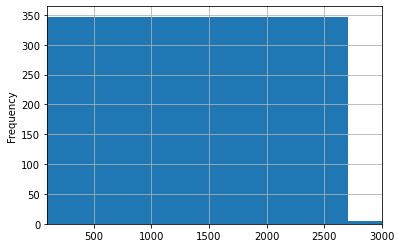

In [68]:
reddits.plot.hist(xlim=(100,3000), bins = 3)
plt.grid()

**using stratified sampling for shuffling proportionate subreddits into the sample**

In [69]:
# reddits[(reddits>= 100) & (reddits<200)] # small = 208

# reddits[(reddits>= 200) & (reddits<800)] # medium = 114

# reddits[reddits>=1000] # large = 23

small = reddits[(reddits>= 100) & (reddits<200)].index.tolist()

medium = reddits[(reddits>= 200) & (reddits<800)].index.tolist()

large = reddits[reddits>=1000] .index.tolist()



In [74]:
X_data = subs_2017_data_clean.drop(["score"], axis=1)
y_data = subs_2017_data_clean["score"]
# y_data = subs_2017_data_clean["score"].values.astype(np.float32)
X_sample, x_, y_sample, y_ = train_test_split(X_data, y_data, 
                                                    test_size=0.5, 
                                                    random_state=101,
                                             stratify=subs_2017_data_clean.subreddit)

In [75]:
# this is the 50% dataset which would be further modelled upon

X_sample.shape

(64212, 10)

In [76]:
def label_reddit(subreddit):
    if subreddit in small:
        return 0
    
    return 1 if subreddit in medium else 2


X_sample["subreddit"] = X_sample['subreddit'].apply(lambda x: label_reddit(x))

# Labelled the small subreddits as 0, medium as 1, large as 2

In [81]:
X_sample["score"] = y_sample

X_sample


,thumbnail,domain,subreddit,gilded,BinarisedNum_Comments,Binarised_is_self,Binarised_over_18,transcript_clean,time_day_hour,polarity,score
1516,self,alle15minuten,0,0,0,1,0,ist es ist es,"(6, 11)",0.0,1
41861,custom,imgur,1,0,0,0,0,oh god,"(6, 19)",1.0,0
18728,self,Overwatch,2,0,0,1,0,probabl best competit someon away decid play a...,"(6, 14)",4.0,0
24770,default,RocketLeagueExchange,2,0,1,1,0,paint insid,"(6, 15)",0.0,0
121087,default,reddituploads,2,0,1,0,0,play go win get elit first time happi one game...,"(0, 10)",6.0,0
...,...,...,...,...,...,...,...,...,...,...,...
94678,default,MMA,1,0,0,1,0,x could good idea,"(0, 6)",1.0,0
52808,self,removalbot,2,0,0,1,0,new eve topaz intern camp central reloc center...,"(6, 22)",-2.0,1
107287,nsfw,RocketLeagueExchange,2,0,0,1,1,price store key less cc4 orang cobalt chakramv...,"(0, 8)",3.0,0
75832,self,Jokes,2,0,1,1,0,met robin parti tri give high five left hang,"(0, 3)",1.0,0


In [82]:

sb_17 = X_sample.sample(n=5000, random_state=101)
sb_17

,thumbnail,domain,subreddit,gilded,BinarisedNum_Comments,Binarised_is_self,Binarised_over_18,transcript_clean,time_day_hour,polarity,score
10963,self,WritingPrompts,1,0,0,1,0,part first inter galact space journey crew ent...,"(6, 12)",-1.0,0
122905,default,dirtykikpals,2,0,0,1,1,horni experienc articul bull call fun,"(0, 10)",1.0,0
94184,default,AskReddit,2,0,0,1,0,first notic someon,"(0, 6)",0.0,0
71523,self,AppNana,1,0,0,1,0,,"(0, 3)",0.0,1
103363,self,LifeProTips,1,0,0,1,0,thumbnail random site time click alway copi li...,"(0, 8)",1.0,0
...,...,...,...,...,...,...,...,...,...,...,...
108035,default,Overwatch,2,0,0,1,0,v unplay wall,"(0, 8)",0.0,0
40212,default,AskReddit,2,0,0,1,0,what common new resolut one stick,"(6, 19)",0.0,0
83763,default,imgur,0,0,0,0,0,rais thi tongu,"(0, 5)",0.0,0
82366,self,hardwareswap,1,0,1,1,0,thin game look thin light use light game trave...,"(0, 4)",4.0,0


In [83]:
sb_17.subreddit.value_counts()

# stratified subreddit sample, having ratio as follows

2    2349
1    1600
0    1051
Name: subreddit, dtype: int64

In [84]:
sb_17.reset_index(drop=True, inplace=True)

In [85]:
corpus = sb_17.transcript_clean.values

vector = TfidfVectorizer(stop_words='english')
sb_17_vect = vector.fit_transform(corpus)


In [86]:
dtm = pd.DataFrame(sb_17_vect.toarray(),columns=vector.get_feature_names())
dtm

,a2,a6,aa,aaditpull3,abandon,abid,abil,abl,abnorm,aboard,...,yu,yuletid,yummi,z9,zac,zero,zeta,zip,zombi,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [90]:
new_columns = sb_17.columns.tolist()
new_columns[0] = "thumb_nail" # thumbnail
new_columns[1] = "url_domain" # domain column
new_columns[2] = "sub_reddit" # subreddit column
new_columns[10] = "up_votes" #score column
sb_17.columns = new_columns
sb_17.head()

,thumb_nail,url_domain,sub_reddit,gilded,BinarisedNum_Comments,Binarised_is_self,Binarised_over_18,transcript_clean,time_day_hour,polarity,up_votes
0,self,WritingPrompts,1,0,0,1,0,part first inter galact space journey crew ent...,"(6, 12)",-1.0,0
1,default,dirtykikpals,2,0,0,1,1,horni experienc articul bull call fun,"(0, 10)",1.0,0
2,default,AskReddit,2,0,0,1,0,first notic someon,"(0, 6)",0.0,0
3,self,AppNana,1,0,0,1,0,,"(0, 3)",0.0,1
4,self,LifeProTips,1,0,0,1,0,thumbnail random site time click alway copi li...,"(0, 8)",1.0,0


In [91]:
sb17_dtm = pd.concat([sb_17, dtm], axis=1)

In [92]:
sb17_dtm.head()

,thumb_nail,url_domain,sub_reddit,gilded,BinarisedNum_Comments,Binarised_is_self,Binarised_over_18,transcript_clean,time_day_hour,polarity,...,yu,yuletid,yummi,z9,zac,zero,zeta,zip,zombi,zone
0,self,WritingPrompts,1,0,0,1,0,part first inter galact space journey crew ent...,"(6, 12)",-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,default,dirtykikpals,2,0,0,1,1,horni experienc articul bull call fun,"(0, 10)",1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,default,AskReddit,2,0,0,1,0,first notic someon,"(0, 6)",0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,self,AppNana,1,0,0,1,0,,"(0, 3)",0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,self,LifeProTips,1,0,0,1,0,thumbnail random site time click alway copi li...,"(0, 8)",1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [93]:
sb17_dtm = pd.get_dummies(sb17_dtm,prefix="is", columns=["thumb_nail", "url_domain"])

In [94]:
sb17_dtm.drop(["transcript_clean"], axis=1, inplace=True)


In [95]:
sb17_dtm

,sub_reddit,gilded,BinarisedNum_Comments,Binarised_is_self,Binarised_over_18,time_day_hour,polarity,up_votes,a2,a6,...,is_xboxone,is_yahoo,is_yashnews,is_yle,is_you-are-the-perfect-thing-to-see,is_youtu,is_youtube,is_youtubemultiplier,is_zeenews,is_zerohedge
0,1,0,0,1,0,"(6, 12)",-1.0,0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,1,1,"(0, 10)",1.0,0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,1,0,"(0, 6)",0.0,0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,1,0,"(0, 3)",0.0,1,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,1,0,"(0, 8)",1.0,0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2,0,0,1,0,"(0, 8)",0.0,0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4996,2,0,0,1,0,"(6, 19)",0.0,0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4997,0,0,0,0,0,"(0, 5)",0.0,0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4998,1,0,1,1,0,"(0, 4)",4.0,0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [96]:
def convert_to_tuple(str_tuple):
    if type(str_tuple) != str:
        return str_tuple
    return tuple(int(num) for num in str_tuple.replace('(', '').replace(')', '').replace('...', '').split(', '))

sb17_dtm["time_day_hour"] = sb17_dtm["time_day_hour"].apply(lambda x: convert_to_tuple(x))
# convert_to_tuple((6, 17))

In [97]:
sb17_dtm["week_day"] = sb17_dtm["time_day_hour"].apply(lambda x: x[0])
sb17_dtm["hour_"] = sb17_dtm["time_day_hour"].apply(lambda x: x[1])

sb17_dtm[["week_day","hour_"]]

,week_day,hour_
0,6,12
1,0,10
2,0,6
3,0,3
4,0,8
...,...,...
4995,0,8
4996,6,19
4997,0,5
4998,0,4


In [98]:
sb17_dtm.drop(["time_day_hour"], axis=1, inplace=True)

**sb17_dtm** is complete numerical data, to be modelled upon Regression functions

In [99]:
sb17_dtm

,sub_reddit,gilded,BinarisedNum_Comments,Binarised_is_self,Binarised_over_18,polarity,up_votes,a2,a6,aa,...,is_yashnews,is_yle,is_you-are-the-perfect-thing-to-see,is_youtu,is_youtube,is_youtubemultiplier,is_zeenews,is_zerohedge,week_day,hour_
0,1,0,0,1,0,-1.0,0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,6,12
1,2,0,0,1,1,1.0,0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,10
2,2,0,0,1,0,0.0,0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,6
3,1,0,0,1,0,0.0,1,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,3
4,1,0,0,1,0,1.0,0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2,0,0,1,0,0.0,0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,8
4996,2,0,0,1,0,0.0,0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,6,19
4997,0,0,0,0,0,0.0,0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,5
4998,1,0,1,1,0,4.0,0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,4


In [141]:
# # Saving checkpoint on DTM

# with open("../data/sb17_dtm.joblib", 'wb') as file:
#     joblib.dump(sb17_dtm, file, compress=1)
#     print(f"Saved sb17_dtm as joblib file to {file}")

Saved sb17_dtm as joblib file to <_io.BufferedWriter name='../data/sb17_dtm.joblib'>


In [ ]:
# # UNCOMMENT AND RUN FOR DIRECT MODELLING

# with open("../data/sb17_dtm.joblib", 'rb') as file:
#     sb17_dtm = joblib.load(file)
# sb17_dtm.head()

In [154]:
pd.read_csv("../data/sb17_dtm.csv", index_col="id").columns

Index(['subreddit', 'gilded', 'BinarisedNum_Comments', 'Binarised_is_self',
       'Binarised_over_18', 'polarity', 'upvotes', 'a2', 'a6', 'aa',
       ...
       'is_yahoo', 'is_yashnews', 'is_yle',
       'is_you-are-the-perfect-thing-to-see', 'is_youtu', 'is_youtube',
       'is_youtubemultiplier', 'is_zeenews', 'is_zerohedge', 'weekday'],
      dtype='object', length=6750)

# Exploratory Data Analysis

**looking into the first 50 top words in the popular posts**

also generating and examining random sample of **_500 posts_**

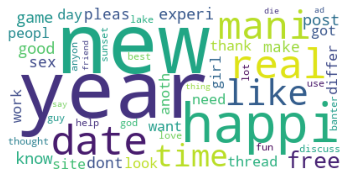

In [80]:
vector_sample = [500,1000]
# change sample size or sampling values above. current values slice the vector between index 500 to 1000

word_cloud = wordcloud.WordCloud(
                                background_color="white", 
                                max_words=50).generate_from_frequencies(
                                                pd.DataFrame(
                                                    subs_2017_vector[vector_sample[0]:vector_sample[1]].todense().tolist(), 
                                                    columns=feature_array).T.sum(axis=1))


# plt.figure(figsize=(12,10))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

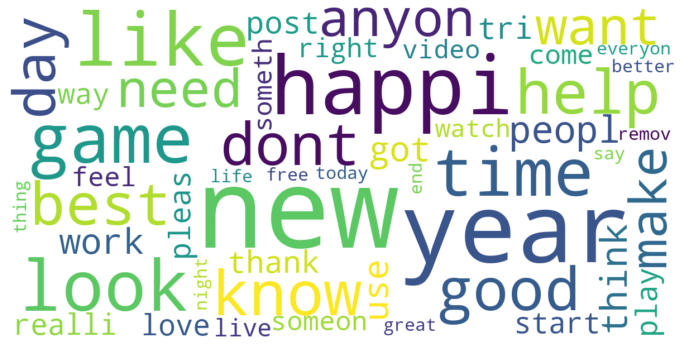

In [81]:
cloud = dict(sorted(list(zip(vectorizer.get_feature_names(), 
                                             subs_2017_vector.sum(0).getA1())), 
                                 key=lambda x: x[1], reverse=True)[:top_n])
cloud_top_words = wordcloud.WordCloud(background_color="white", width=1200, height=600, max_font_size=200).generate_from_frequencies(frequencies=cloud)
plt.figure(figsize=(12,10))
plt.imshow(cloud_top_words, interpolation="bilinear")
plt.axis("off")
plt.show()


In [82]:
subs_2017_data_clean.groupby("subreddit")["score"].count()

subreddit
2007scape         426
Advice            208
AdviceAnimals     353
AgeplayPenPals    289
Amd               104
                 ... 
worldpowers       100
wow               295
xboxone           256
youtube           194
youtubehaiku      157
Name: score, Length: 353, dtype: int64

In [83]:
subs_2017_data_clean["subreddit"].value_counts()

AskReddit               7907
RocketLeagueExchange    7020
removalbot              3119
The_Donald              3041
GlobalOffensiveTrade    2820
                        ... 
gentlemanboners          100
AskWomen                 100
magicTCG                 100
skyrimmods               100
automaticmemes           100
Name: subreddit, Length: 353, dtype: int64

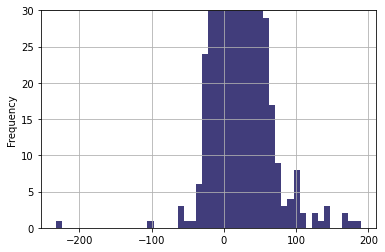

In [84]:
only_sentiment_polarity["polarity"].plot.hist(ylim=(0,30), bins = 50, color=sns.color_palette("mako")[1])
plt.grid()

<BarContainer object of 2 artists>

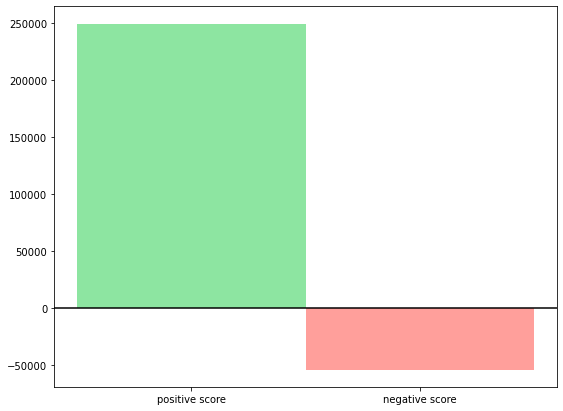

In [85]:
x = ["positive score", "negative score"]
negative_data = [0,only_sentiment_polarity[only_sentiment_polarity["polarity"]<0]["polarity"].sum()]
positive_data = [only_sentiment_polarity[only_sentiment_polarity["polarity"]>0]["polarity"].sum(), 0]

fig = plt.figure(figsize=(9,7))
ax = plt.subplot(111)
plt.axhline(0, color='black')
ax.bar(x, negative_data, width=1, color=sns.color_palette('pastel')[3])
ax.bar(x, positive_data, width=1, color=sns.color_palette('pastel')[2])

[(0.0, 1000.0)]

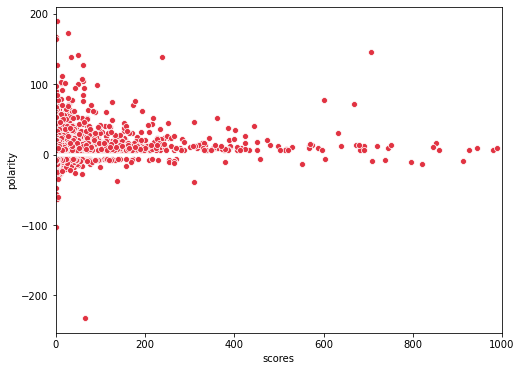

In [86]:
plt.figure(figsize=(8,6))
sns.scatterplot(y = only_sentiment_polarity[abs(only_sentiment_polarity["polarity"]) > 5]["polarity"], 
                x=only_sentiment_polarity[abs(only_sentiment_polarity["polarity"]) > 5]["scores"], 
                color = sns.color_palette("rocket")[3]).set(xlim = (0,1000))

**visualizing words contained in top 50 negative posts and top 50 positive posts**

we can check by popularity too by tweaking the parameters and sorting by scores

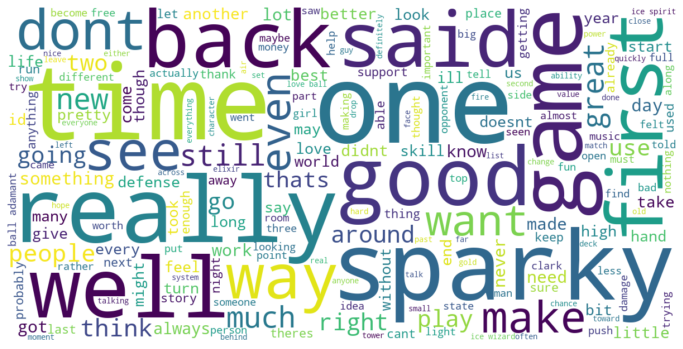

In [87]:
top_n_pos = only_sentiment_polarity[only_sentiment_polarity["polarity"] > 0].sort_values(["polarity"], ascending=False)[:50]

para_pos = " ".join(top_n_pos["sentence"].tolist())

plt.figure(figsize=(12,10))
plt.imshow(wordcloud.WordCloud(background_color='white', width=1200, height=600, max_font_size=200).generate(para_pos), interpolation="bilinear")
plt.axis("off")
plt.show()

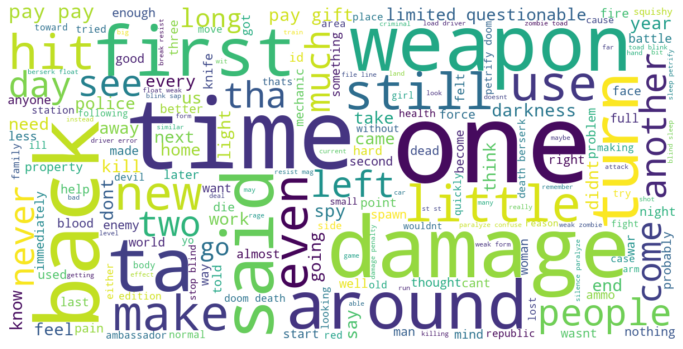

In [88]:
top_n_neg = only_sentiment_polarity[only_sentiment_polarity["polarity"] < 0].sort_values(["polarity"])[:50]

para_neg = " ".join(top_n_neg["sentence"].tolist())

plt.figure(figsize=(12,10))
plt.imshow(wordcloud.WordCloud(background_color='white', width=1200, height=600, max_font_size=200).generate(para_neg), interpolation="bilinear")
plt.axis("off")
plt.show()

# Modelling

In [229]:
X = sb17_dtm.drop(["up_votes"], axis=1)
y = sb17_dtm[["up_votes"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

,sub_reddit,gilded,BinarisedNum_Comments,Binarised_is_self,Binarised_over_18,polarity,a2,a6,aa,aaditpull3,...,is_yashnews,is_yle,is_you-are-the-perfect-thing-to-see,is_youtu,is_youtube,is_youtubemultiplier,is_zeenews,is_zerohedge,week_day,hour_
0,1,0,0,1,0,-1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,6,12
1,2,0,0,1,1,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,10
2,2,0,0,1,0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,6
3,1,0,0,1,0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,3
4,1,0,0,1,0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2,0,0,1,0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,8
4996,2,0,0,1,0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,6,19
4997,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,5
4998,1,0,1,1,0,4.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,4


### Baseline Score

In [327]:
base_line_score = int(np.ceil(sb17_dtm["up_votes"].mean()))

base_line_score = np.zeros(1000) + base_line_score

print("R2 Score BASELINE")
print(r2_score(y_test, base_line_score))

print("Accuracy Score BASELINE")
print(accuracy_score(y_test, base_line_score))

print("ROC AUC Score BASELINE")
print(roc_auc_score(y_test, base_line_score))

R2 Score BASELINE
-10.904761904761907
Accuracy Score BASELINE
0.084
ROC AUC Score BASELINE
0.5


### Random Forest

In [104]:
rf = RandomForestClassifier(n_jobs=-1, n_estimators=200, min_samples_leaf=10)

start = time.time()
print(rf.fit(X_train, y_train))
print("time taken (in minutes) to train: ", (time.time() - start)/60)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)
time taken (in minutes) to train:  0.035295478502909344


In [107]:
rf_res = rf.predict(X_test)

print("R2 Score RANDOM FOREST")
print(r2_score(y_test, rf_res))

print("Accuracy Score RANDOM FOREST")
print(accuracy_score(y_test, rf_res))

print("ROC AUC Score RANDOM FOREST")
print(roc_auc_score(y_test, rf_res))


R2 Score RANDOM FOREST
0.2072156373466416
Accuracy Score RANDOM FOREST
0.939
ROC AUC Score RANDOM FOREST
0.6369047619047619


### K-Nearest Neighbour

In [109]:
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean', n_jobs=-1)

start = time.time()
knn.fit(X_train, y_train)
print("time taken (in minutes) to train: ", (time.time() - start)/60)

time taken (in minutes) to train:  0.35336191256841026


In [111]:
knn_res = knn.predict(X_test)

print("R2 Score KNN")
print(r2_score(y_test, knn_res))

print("Accuracy Score KNN")
print(accuracy_score(y_test, knn_res))

print("ROC AUC Score KNN")
print(roc_auc_score(y_test, knn_res))

R2 Score KNN
0.29819089207735483
Accuracy Score KNN
0.946
ROC AUC Score KNN
0.7434497816593887


### Model Comparison

In [332]:
error_rate = {
    "baseline": {
        "r2": r2_score(y_test, base_line_score),
        "accuracy": accuracy_score(y_test, base_line_score),
        "roc_aoc": roc_auc_score(y_test, base_line_score)
    },
    "random_forest": {
        "r2": r2_score(y_test, rf_res),
        "accuracy": accuracy_score(y_test, rf_res),
        "roc_aoc": roc_auc_score(y_test, rf_res)
    },
    "knn": {
        "r2": r2_score(y_test, knn_res),
        "accuracy": accuracy_score(y_test, knn_res),
        "roc_aoc": roc_auc_score(y_test, knn_res)
    },

}

pd.DataFrame(error_rate)

,baseline,random_forest,knn
r2,-10.904762,0.207216,0.298191
accuracy,0.084000,0.939000,0.946000
roc_aoc,0.500000,0.636905,0.743450


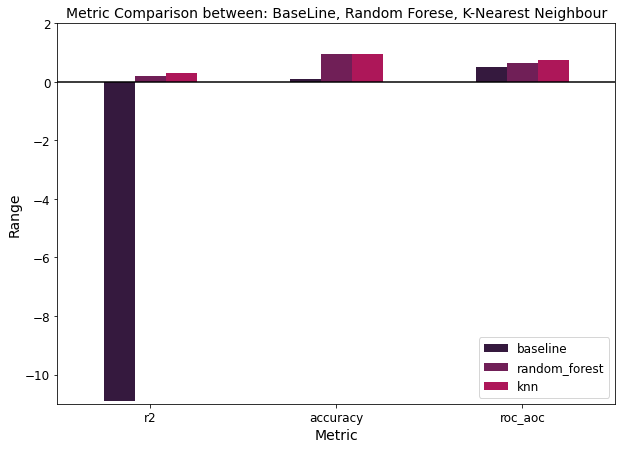

In [346]:
pd.DataFrame(error_rate).plot.bar(color= sns.color_palette('rocket'), fontsize = 12, figsize = (10,7), ylim = (-11,2))
plt.axhline(0, color='black')
plt.xticks(rotation = 0)
plt.xlabel("Metric", fontsize = 14)
plt.ylabel("Range", fontsize = 14)
plt.title("Metric Comparison between: BaseLine, Random Forese, K-Nearest Neighbour", fontsize = 14)
plt.legend(fontsize = 12);

## Hyperparameter Tuning

[colab-file-for-tuning](https://colab.research.google.com/drive/1DeSt4peRsR3h4fG-QUsLnfzWqz_KueRM?usp=sharing)

 total_features = 6750  
 domain = 602  
 thumbnail = 6  
 main_feats = 6  
 vector = 6134  
 weekday + hour = 2  
6134 + 6 + 6 + 602 + 2 == 6750

### Random-Forest

In [114]:
rf1 = RandomForestRegressor(n_jobs=-1, criterion = 'gini')

rf_params = [{"max_depth": [5,10,15],
              "n_estimators": [100,200,350],
             }]

cv = KFold(n_splits=3, random_state=101)
RF = GridSearchCV(rf1,rf_params,scoring='accuracy',cv=3, n_jobs=-1)

In [121]:
RF.fit(X_train,y_train)

GridSearchCV(cv=3, error_score=nan,
                      estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=False,
                                            

In [122]:
RF.best_params_

{'max_depth': 15, 'n_estimators': 350}


In [123]:
rf_result = RF.predict(X_test)

In [124]:
print(accuracy_score(y_test,rf_result))
print(r2_score(y_test,rf_result))
print(roc_auc_score(y_test,rf_result))

0.928
0.21393947333944718
0.6470588235294118


### KNN

In [127]:
knn1 = KNeighborsClassifier(n_jobs=-1)


knn_params = [{'n_neighbors':[5,10,20],'leaf_size':[15,30,50],'algorithm':['auto','ball_tree']}]



cv = KFold(n_splits=3, random_state=101)
KNN = GridSearchCV(knn1,knn_params,scoring='accuracy',cv=3, n_jobs=-1)

In [310]:
KNN.fit(X_train,y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=-1,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=-1,
             param_grid=[{'algorithm': ['auto', 'ball_tree'],
                          'leaf_size': [15, 30, 50],
                          'n_neighbors': [5, 10, 20]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)


In [311]:
KNN.best_params_

{'algorithm': 'auto', 'leaf_size': 30, 'n_neighbors': 5}


In [312]:
knn_result = KNN.predict(X_test)

print(accuracy_score(y_test,knn_result))
print(r2_score(y_test,knn_result))
print(roc_auc_score(y_test,knn_result))

0.932
0.2576095025983668
0.7014280099567666


## Saving files

In [276]:
with open("../resources/knn_final.joblib", 'wb') as knn_file:
    joblib.dump(knn, knn_file, compress=1)

with open("../resources/rf_final.joblib", 'wb') as rf_final:
    joblib.dump(rf, rf_final, compress=1)

In [141]:
with open("../resources/vector.joblib", 'wb') as vect:
    joblib.dump(vector, vect, compress = 1)

In [347]:

with open("../resources/small.joblib", 'wb') as s:
    joblib.dump(small,s,compress=1)
    
with open("../resources/medium.joblib", 'wb') as m:
    joblib.dump(medium,m,compress=1)
    
with open("../resources/large.joblib", 'wb') as l:
    joblib.dump(large,l,compress=1)